In [2]:
from elasticsearch import Elasticsearch
import json
import requests

import eslogin

import datetime
import time

import numpy as np
from numpy.random import randn
import pandas as pd
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import math

from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

#Get familiar with the data

make sure ES is up and running

In [3]:
res = requests.get('http://elasticsearch-events.fal.zenit.io:9200/',auth=(eslogin.user,eslogin.password))
print(res.content)

{
  "status" : 200,
  "name" : "es02.fal.zenit.io",
  "cluster_name" : "zenit-events",
  "version" : {
    "number" : "1.5.2",
    "build_hash" : "62ff9868b4c8a0c45860bebb259e21980778ab1c",
    "build_timestamp" : "2015-04-27T09:21:06Z",
    "build_snapshot" : false,
    "lucene_version" : "4.10.4"
  },
  "tagline" : "You Know, for Search"
}



connect to the cluster

In [4]:
#import elasticsearch 

es = Elasticsearch([{'host': 'elasticsearch-events.fal.zenit.io', 'port': 9200}],http_auth=('zenit','6nAzJGhq'))

do some searching

In [10]:
result = es.search(index="events-2015.06.06", body={'query': {'match': { 'et' : 'AD_CLICK' }}}, size = 1)

In [11]:
print json.dumps(result, indent=2)

{
  "hits": {
    "hits": [
      {
        "_score": 8.092939, 
        "_type": "AD_CLICK", 
        "_id": "AU3GS49JKbAs8MwsdXY2", 
        "_source": {
          "ci": null, 
          "co": "ITA", 
          "ai": 67, 
          "ip": "151.33.17.29", 
          "ak": 130, 
          "pbep": 70, 
          "vw_drtn": 0, 
          "cr": 330, 
          "et": "AD_CLICK", 
          "id": "zenit_afe23882-b5be-4237-8d20-ef4f47d0d6c4_330", 
          "plfm": "android", 
          "pp": 0, 
          "pv": "4.4.4", 
          "li": 210, 
          "pg": 0, 
          "rgn": "ITA-12", 
          "fr": false, 
          "vw_perc": 0, 
          "ernc": 0, 
          "ssp": "zenit_marketplace", 
          "br": "Chrome 43.0.2357.92", 
          "dt": "android", 
          "arch": false, 
          "lidp": 0, 
          "dp": 0, 
          "cvpc": 2850000, 
          "sdpt": 0, 
          "created_at": "2015-06-06T00:35:50.207Z", 
          "isp": "Infostrada", 
          "cty": "Turin", 
 

It seems to work!

the structure of result (JSON) is a python dictionary:

In [12]:
result.keys()

[u'hits', u'_shards', u'took', u'timed_out']

In [13]:
result['hits'].keys()

[u'hits', u'total', u'max_score']

In [14]:
len(result['hits']['hits'])

1

But it only shows 10/103 hits... (6/6/15)
Can consider the following way to get more data:
https://www.elastic.co/guide/en/elasticsearch/guide/current/pagination.html
https://elasticsearch-py.readthedocs.org/en/master/api.html#elasticsearch.Elasticsearch.search

In [15]:
es.count(index="events-2015.06.06", body={'query': {'match': { 'et' : 'AD_CLICK' }}})['count']

103

In [16]:
es.count(index="events-2015.06.06", body={'query': {'bool': {'must':[{'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']

84

Note: true needs to be 'true' in Python API here

In [17]:
result = es.search(index="events-2015.06.06", body={'query': {'bool': {'must':[{'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}}, size = 84)

In [18]:
result['hits']['hits'][0]

{u'_id': u'AU3GS49JKbAs8MwsdXY2',
 u'_index': u'events-2015.06.06',
 u'_score': 8.064973,
 u'_source': {u'ai': 67,
  u'ak': 130,
  u'arch': False,
  u'br': u'Chrome 43.0.2357.92',
  u'ci': None,
  u'co': u'ITA',
  u'cr': 330,
  u'created_at': u'2015-06-06T00:35:50.207Z',
  u'cty': u'Turin',
  u'cvpc': 2850000,
  u'dp': 0,
  u'dt': u'android',
  u'ernc': 0,
  u'et': u'AD_CLICK',
  u'fr': False,
  u'id': u'zenit_afe23882-b5be-4237-8d20-ef4f47d0d6c4_330',
  u'ip': u'151.33.17.29',
  u'isp': u'Infostrada',
  u'li': 210,
  u'lidp': 0,
  u'pbep': 70,
  u'pg': 0,
  u'plfm': u'android',
  u'pp': 0,
  u'pv': u'4.4.4',
  u'rgn': u'ITA-12',
  u'sdpt': 0,
  u'ssp': u'zenit_marketplace',
  u'ua': u'Mozilla/5.0 (Linux; Android 4.4.4; SM-J100H Build/KTU84P) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.92 Mobile Safari/537.36',
  u'vw_drtn': 0,
  u'vw_perc': 0},
 u'_type': u'AD_CLICK'}

In [118]:
type(result['hits']['hits'])

list

Convert to python pandas dataframe

In [19]:
df1 = pd.DataFrame([datum for datum in result['hits']['hits']])
#df2 = pd.DataFrame([datum for datum in Table1['_source']])
#merge = pd.concat([df1, df2], axis=1)

Examine each column and looks like I do not need to add df1 for now (most information can be found in df2, just except for "id" which I do not understand now.

# Download all "click" data

In [5]:
datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')

'2015-06-10 23:59:23'

Count the number of valid clicks so far

In [22]:
es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']

9159

In [69]:
clicks = es.search(index="events-*", body={'query': {'bool': {'must':[{'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}}, size = 9159)

In [70]:
clicks_df = pd.DataFrame([datum['_source'] for datum in clicks['hits']['hits']])

In [71]:
clicks_df.shape

(9159, 46)

In [72]:
clicks_df.to_csv("../data/clicks_150608.tab",sep='\t',encoding='utf-8')

In [38]:
clicks_df = pd.read_csv("../data/clicks_150608.tab",sep='\t',index_col=0,encoding='utf-8')

Examine each column - each potential feature

In [73]:
len(clicks_df.columns.values)

46

# 46 columns:

## 0 'ai', 
## 1 'ak',    — APP KEY
## 2 'arch', — ARCHIVED
## 3 'au',    — AD UNIT TYPE
## 4 'br',    — BROWSER
## 5 'ci',     — CAMPAIGN ID
## 6 'cn',    — CONNECTION
## 7 'co',    — COUNTRY ISO3
## 8 'cr',     — CREATIVE ID
## 9 'created_at',
## 10 'cty',   — CITY
## 11 'curl',  — CLICK URL
## 12 'cvpc',— CONVERSION PRICE CENTS
## 13 'di',
## 14 'dnt', — DO NOT TRACK
## 15 'dp',  — DELIVERY PRICE CENTS
## 16 'dt',   — DEVICE TYPE
## 17 'ek',   — EXCHANGE KEY
## 18 'ernc',— EARNINGS CENTS
## 19 'et',    — EVENT TYPE
## 20 'ex',
## 21 'fr',    — FRAUD
## 22 'id',    — AD DELIVERY TOKEN
## 23 'ip',    — REMOTE IP
## 24 'isp',
## 25 'js',    — JS VERSION
## 26 'la',    — LANGUAGE
## 27 'li',     — LINE ITEM ID
## 28 'lidp', — LINE ITEM DISCOUNT PERCENT
## 29 'ma',   — MAC ADDRESS
## 30 'pb',   — PINGBACK
## 31 'pbep',— PUBLISHER EARNINGS PERCENT
## 32 'pg',   — PAGE
## 33 plfm', — PLATFORM
## 34 'pp',   — PER PAGE
## 35 'pv',   — PLATFORM VERSION
## 36 'rgn',  — REGION
## 37 'sdpt',— SESSION DEPTH
## 38 'si',    — SESSION ID
## 39 'ssp', — SUPPLY SIDE PLATFORM
## 40 'sv',   — SDK VERSION
## 41 'ua',   — USER AGENT
## 42 'uid',
## 43 'vt',    — VIEWER TOKEN
## 44 'vw_drtn',   — VIEWABILITY DURATION
## 45 'vw_perc'   — VIEWABILITY PERCENT

In [19]:
pd.options.display.max_rows = 3
pd.options.display.max_columns = 50
clicks_df

,ai,ak,arch,au,br,ci,cn,co,cr,created_at,cty,curl,cvpc,di,dnt,dp,dt,ek,ernc,et,ex,fr,id,ip,isp,js,la,li,lidp,ma,pb,pbep,pg,plfm,pp,pv,rgn,sdpt,si,ssp,sv,ua,uid,vt,vw_drtn,vw_perc
0,51,124,False,NaN,Other 0.0,103,NaN,GBR,157,2015-05-10T04:41:11.915Z,Eastbourne,NaN,NaN,NaN,NaN,300000,other,NaN,210000,AD_CLICK,NaN,False,zenit_d7dccf46-0e71-4b35-b682-6f66329de8ef_157,5.80.244.135,BT,NaN,NaN,85,0,NaN,NaN,70,0,NaN,0,unknown,GBR-E2,1,NaN,zenit_marketplace,NaN,Chelsea/4.5.1 CFNetwork/711.3.18 Darwin/14.0.0,56545422-1F56-4D29-BB75-2B6B9CE58C80,NaN,0,0
1,67,130,False,NaN,Android 4.0,NaN,NaN,ITA,218,2015-05-10T20:52:50.992Z,Massafra,NaN,NaN,NaN,NaN,0,android,NaN,0,AD_CLICK,NaN,False,zenit_b5826dcd-edf9-4b68-b835-4762b6c23eb4_218,2.226.115.192,Fastweb,NaN,NaN,130,0,NaN,NaN,70,0,android,0,4.4.4,ITA-13,0,NaN,zenit_marketplace,NaN,Mozilla/5.0 (Linux; U; Android 4.4.4; it-it; S...,NaN,NaN,0,0
2,93,143,False,NaN,Other 0.0,NaN,NaN,USA,222,2015-05-12T17:55:12.568Z,Mountain View,NaN,NaN,NaN,NaN,0,other,NaN,0,AD_CLICK,NaN,False,zenit_eaf4cdea-dc29-4bd7-81e8-e71c071a0870_222,66.249.78.238,Googlebot,NaN,NaN,133,0,NaN,NaN,70,0,NaN,0,unknown,USA-CA,0,NaN,zenit_marketplace,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,NaN,NaN,0,0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [173]:
clicks_df['sv'].value_counts()

reprehenderit    21
aut               1
dtype: int64

array([[<matplotlib.axes.AxesSubplot object at 0x7f40a44a1510>]], dtype=object)

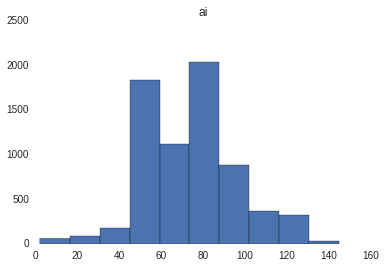

In [171]:
#plot_ind = [0, 2, 5, 8, 12, 15, 18, 21, 27, 28, 31, 32, 34, 37, 44, 45]

clicks_df[[0]].hist()

Make subset of the dataframe excluding the features that do not make sense for now OR not seem to be important OR too many NAN...

Remove duplicated events:

In [40]:
clicks_uniq = clicks_df.loc[np.where(np.unique(clicks_df['created_at']))[0], :]

In [184]:
clicks_uniq.to_csv("../data/clicks_uniq_150610.tab",sep='\t',encoding='utf-8')

Checked in Shell: seems to be only one duplicated time

In [41]:
clicks_df_small = clicks_uniq[['ai','ak','br','co','cr','created_at','cty','dp','dt','ernc','isp','li','lidp','pbep','plfm','rgn','sdpt','ssp','ua','vw_drtn','vw_perc']]

In [42]:
clicks_df_small.shape

(9158, 21)

Check the number of NaN in each column:

In [87]:
type(clicks_df_small)

pandas.core.frame.DataFrame

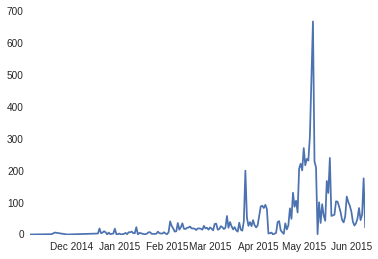

In [43]:
def get_date(timestring):
    mytime = timestring.split('.')[0]
    return datetime.datetime.strptime(mytime, '%Y-%m-%dT%X')
clicks_df_small['created_at'].apply(get_date).apply(datetime.datetime.date).value_counts().sort_index().plot()

#Dealing with missing data

In [16]:
pd.notnull(clicks_df_small['rgn']).sum()

2840

In [154]:
clicks_df_small.count()

ai            6920
ak            9156
br            9083
co            9137
cr            9158
created_at    9158
cty           5763
dp            9158
dt            9083
ernc          9158
isp           9115
li            9158
lidp          9158
pbep          9158
plfm          3426
rgn           2840
sdpt          9143
ssp           7279
ua            9105
vw_drtn       8432
...
ai            6920
ak            9156
br            9083
co            9137
cr            9158
created_at    9158
cty           5763
dp            9158
dt            9083
ernc          9158
isp           9115
li            9158
lidp          9158
pbep          9158
plfm          3426
rgn           2840
sdpt          9143
ssp           7279
ua            9105
vw_drtn       8432
vw_perc       8432
Length: 21, dtype: int64

Not sure what imputation method, of if any, would be suitable for this case.. Try discarding the entire row first...

In [44]:
clicks_df_small_dropna = clicks_df_small.dropna(axis=0)

In [20]:
clicks_df_small_dropna

,ai,ak,br,co,cr,created_at,cty,dp,dt,ernc,isp,li,lidp,pbep,plfm,rgn,sdpt,ssp,ua,vw_drtn,vw_perc
1,67,130,Android 4.0,ITA,218,2015-05-10T20:52:50.992Z,Massafra,0,android,0,Fastweb,130,0,70,android,ITA-13,0,zenit_marketplace,Mozilla/5.0 (Linux; U; Android 4.4.4; it-it; S...,0,0
3,87,140,Chrome 42.0.2311.47,GBR,257,2015-05-12T18:02:23.940Z,Maidenhead,1500000,iphone,1050000,Iomart Hosting Limited,194,0,70,ios,GBR-P9,0,zenit_marketplace,Mozilla/5.0 (iPhone; CPU iPhone OS 8_3 like Ma...,0,0
5,93,143,Android 4.0,FRA,257,2015-05-12T22:16:44.314Z,Los Angeles,100000,android,70000,Free SAS,194,0,70,android,FRA-A8,0,zenit_marketplace,Mozilla/5.0 (Linux; U; Android 4.4.4; en-US; G...,0,0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Continue with 1042 cases for now...
Checking the frequency of different values for each categorical feature:

In [21]:
clicks_df_small_dropna['dt'].value_counts()

android    1004
iphone       65
ipad         13
dtype: int64

'ua' does not seem to be interesting..

In [45]:
clicks_df_small_dropna = clicks_df_small_dropna.drop('ua', 1)

In [23]:
clicks_df_small_dropna.shape

(1082, 20)

#Parsing each column

In [46]:
clicks_df_small_dropna_parse = clicks_df_small_dropna

remove version number in the browser information:

In [47]:
def get_browser(br_vs):
    return br_vs.split()[0]
clicks_df_small_dropna_parse['br'] = clicks_df_small_dropna_parse['br'].apply(get_browser)

In [26]:
clicks_df_small_dropna_parse['br'].value_counts()

Android    611
Chrome     411
iPhone      48
...
Android    611
Chrome     411
iPhone      48
iPad        12
Length: 4, dtype: int64

parsing date and time information:

In [48]:
def get_date(timestring):
    mytime = timestring.split('.')[0]
    return datetime.datetime.strptime(mytime, '%Y-%m-%dT%X')
#get_date("2015-05-10T20:52:50.992Z")
clicks_df_small_dropna_parse['created_at'] = clicks_df_small_dropna_parse['created_at'].apply(get_date)

In [28]:
clicks_df_small_dropna_parse['created_at'].value_counts()

2015-05-07 10:09:33    2
2015-05-07 11:59:20    2
2015-05-06 14:44:01    2
2015-05-07 14:21:23    2
2015-05-06 17:34:43    2
2015-05-06 21:44:06    2
2015-05-06 17:39:42    2
2015-05-07 14:23:22    2
2015-05-07 12:43:22    2
2015-05-06 04:20:45    2
2015-05-06 17:41:42    2
2015-05-07 01:54:16    2
2015-05-07 17:24:46    2
2015-05-07 14:25:22    2
2015-05-06 17:42:42    2
2015-05-06 15:43:13    2
2015-05-07 12:03:21    2
2015-05-06 15:09:32    2
2015-05-06 03:09:29    2
2015-05-07 12:35:22    2
2015-05-07 10:55:47    2
2015-05-06 03:12:29    2
2015-05-07 14:18:22    2
2015-05-06 01:43:57    2
2015-05-07 01:50:17    2
2015-05-06 11:15:38    2
2015-05-20 19:50:43    2
2015-05-06 19:40:41    2
2015-05-06 01:39:27    2
2015-05-06 11:18:37    2
2015-05-06 15:00:32    2
2015-05-06 19:52:51    2
2015-05-06 19:55:02    2
2015-05-06 17:38:43    2
2015-05-07 01:51:16    2
2015-05-07 12:18:21    2
2015-05-05 18:03:17    2
2015-05-06 15:03:32    2
2015-05-06 14:54:32    2
2015-05-07 09:41:38    2


In [49]:
#clicks_df_small_dropna_parse['created_at'].iloc[0].date()
clicks_df_small_dropna_parse['date'] = clicks_df_small_dropna_parse['created_at'].apply(datetime.datetime.date)

In [30]:
clicks_df_small_dropna_parse['date'].value_counts().sort_index()

2015-05-05     52
2015-05-06    189
2015-05-07    211
2015-05-08     38
2015-05-09     25
2015-05-10      1
2015-05-11     12
2015-05-12      6
2015-05-13     13
2015-05-14      2
2015-05-15     11
2015-05-16     56
2015-05-17     42
2015-05-18     59
2015-05-19     11
2015-05-20     11
2015-05-21      4
2015-05-22      5
2015-05-23      5
2015-05-24      7
2015-05-25      9
2015-05-26      7
2015-05-27      5
2015-05-28     20
2015-05-29     21
2015-05-30     31
2015-05-31     27
2015-06-01     13
2015-06-02     23
2015-06-03      5
2015-06-04     12
2015-06-05     28
2015-06-06     37
2015-06-07     19
2015-06-08     25
2015-06-09     37
...
2015-05-05     52
2015-05-06    189
2015-05-07    211
2015-05-08     38
2015-05-09     25
2015-05-10      1
2015-05-11     12
2015-05-12      6
2015-05-13     13
2015-05-14      2
2015-05-15     11
2015-05-16     56
2015-05-17     42
2015-05-18     59
2015-05-19     11
2015-05-20     11
2015-05-21      4
2015-05-22      5
2015-05-23      5
2015-0

Hmm, all data before 2015-05-05 were missing... maybe the elesticsearch schema has been changed that day, or some information was collected from that day? Need to take to look later!

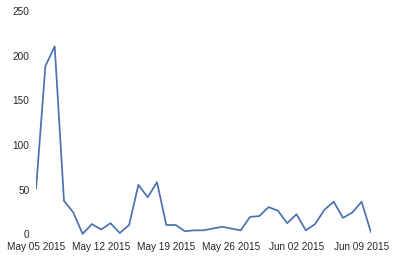

In [50]:
clicks_df_small_dropna_parse['date'].value_counts().sort_index().plot()

In [51]:
def get_time_of_day(datetimeObj):
    hour = datetimeObj.hour
    result = 'Evening'
    if hour < 12:
        result = 'Morning'
    elif hour < 16:
        result = 'Afternoon'
    return result
clicks_df_small_dropna_parse['time'] = clicks_df_small_dropna_parse['created_at'].apply(get_time_of_day)

In [33]:
clicks_df_small_dropna_parse['time'].value_counts()

Evening      429
Morning      419
Afternoon    234
dtype: int64

In [34]:
clicks_df_small_dropna_parse

,ai,ak,br,co,cr,created_at,cty,dp,dt,ernc,isp,li,lidp,pbep,plfm,rgn,sdpt,ssp,vw_drtn,vw_perc,date,time
1,67,130,Android,ITA,218,2015-05-10 20:52:50,Massafra,0,android,0,Fastweb,130,0,70,android,ITA-13,0,zenit_marketplace,0,0,2015-05-10,Evening
3,87,140,Chrome,GBR,257,2015-05-12 18:02:23,Maidenhead,1500000,iphone,1050000,Iomart Hosting Limited,194,0,70,ios,GBR-P9,0,zenit_marketplace,0,0,2015-05-12,Evening
5,93,143,Android,FRA,257,2015-05-12 22:16:44,Los Angeles,100000,android,70000,Free SAS,194,0,70,android,FRA-A8,0,zenit_marketplace,0,0,2015-05-12,Evening
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Looks pretty similar...
Let me put these three lines into one plot

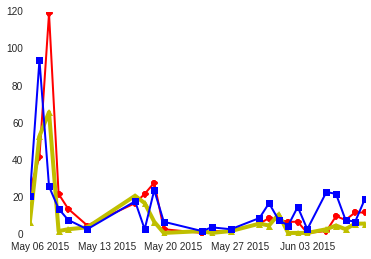

In [52]:
morning = clicks_df_small_dropna_parse.loc[clicks_df_small_dropna_parse['time'] == 'Morning',]['date'].value_counts().sort_index()
afternoon = clicks_df_small_dropna_parse.loc[clicks_df_small_dropna_parse['time'] == 'Afternoon',]['date'].value_counts().sort_index()
evening = clicks_df_small_dropna_parse.loc[clicks_df_small_dropna_parse['time'] == 'Evening',]['date'].value_counts().sort_index()
merge = pd.concat([morning, afternoon, evening], axis=1, join='inner')
merge.columns = ['morning', 'afternoon', 'evening']
styles = ['ro-','y^-','bs-']
linewidths = [2, 4, 2]
fig, ax = plt.subplots()
for col, style, lw in zip(merge.columns, styles, linewidths):
    merge[col].plot(style=style, lw=lw, ax=ax)

Need to add ads and app type/category information. Later...

#Prepare the first but small positive set (training + validation + test)

In [36]:
#positive1 = clicks_df_small_dropna_parse[['br','co','cty','rgn','time','dt','plfm','isp','ssp','dp','ernc','cr','li','lidp','pbep','sdpt','vw_drtn','vw_perc']]
#positive1.shape
clicks_df_small_dropna_parse['created_at'].apply(lambda x:x.month).value_counts()

5    880
6    202
dtype: int64

Plan: use 880 from May as training set, and use 202 from June as validation/test set

Need to clean odd chars in the city field:

In [173]:
np.unique(clicks_df_small_dropna_parse['cty'])

array([u'Aberdeen', u'Abuja', u'Accra', u'Acerra', u'Adelfia', u'Agropoli',
       u'Albenga', u'Albuquerque', u'Alghero', u'Almenno San Salvatore',
       u'Altamura', u'Amelia', u'Amsterdam', u'Antioch', u'Antwerpen',
       u'Apo', u'Arlington', u'Arzignano', u'Asti', u'Atlanta', u'Austin',
       u'Aversa', u'Azuqueca De Henares', u'Bari', u'Barolo',
       u'Basingstoke', u'Bastiglia', u'Beckenham', u'Bergamo', u'Biella',
       u'Binago', u'Birmingham', u'Bitonto', u'Bologna', u'Bolton',
       u'Borgia', u'Borgo San Lorenzo', u'Boston', u'Brampton', u'Brescia',
       u'Brindisi', u'Bristol', u'Brooklyn', u'Brugherio', u'Brussels',
       u'Budrio', u'Buffalo', u'B\xe9nin', u'Cagliari', u'Cairo',
       u'Campogalliano', u'Cape Town', u'Caravonica', u'Cardito',
       u'Casoria', u'Castelfidardo', u'Castenedolo', u'Catania',
       u'Catanzaro', u'Cavriana', u'Cesena', u'Chicago', u'Cittadella',
       u'Civitanova Marche', u'Clifton', u'Clinton', u'Cotonou',
       u'Crescentin

In [53]:
np.unique(clicks_df_small_dropna_parse['cty'])[47].encode('ascii', 'ignore').decode('ascii')

u'Bnin'

In [54]:
clicks_df_small_dropna_parse['cty'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))

1                        Massafra
3                      Maidenhead
5                     Los Angeles
8                           Hanoi
9                             Apo
31                          Lagos
38                       Pasadena
53                    Basingstoke
69                           Kiev
82                        Houston
121                         Lagos
123                          Bari
128                         Lagos
130                         Lagos
136                         Accra
144                   Scarborough
149                     Arlington
150                 San Francisco
158                   Los Angeles
159                          Kiev
164                      Brooklyn
167                          Kiev
168                          Kiev
169                       Lansing
171                         Hanoi
175                 San Francisco
176                 San Francisco
227                        Taguig
231                      Pasadena
242           

In [55]:
pd.get_dummies(clicks_df_small_dropna_parse['cty'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii')),prefix='cty')

cty_Aberdeen  cty_Abuja  cty_Accra  cty_Acerra  cty_Adelfia  cty_Agropoli  \
1             0          0          0           0            0             0   
3             0          0          0           0            0             0   
5             0          0          0           0            0             0   
            ...        ...        ...         ...          ...           ...   

   cty_Albenga  cty_Albuquerque  cty_Alghero  cty_Almenno San Salvatore  \
1            0                0            0                          0   
3            0                0            0                          0   
5            0                0            0                          0   
           ...              ...          ...                        ...   

   cty_Altamura  cty_Amelia  cty_Amsterdam  cty_Antioch  cty_Antwerpen  \
1             0           0              0            0              0   
3             0           0              0            0              0   
5             0           0              0            0              0   
            ...         ...            ...          ...            ...   

   cty_Apo  cty_Arlington  cty_Arzignano  cty_Asti  cty_Atlanta  cty_Austin  \
1        0              0              0         0            0           0   
3        0              0              0         0            0           0   
5        0              0              0         0            0           0   
       ...            ...            ...       ...          ...         ...   

   cty_Aversa  cty_Azuqueca De Henares  cty_Bari  cty_Barolo  cty_Basingstoke  \
1           0                        0         0           0                0   
3           0                        0         0           0                0   
5           0                        0         0           0                0   
          ...                      ...       ...         ...              ...   

   cty_Bastiglia  cty_Beckenham  cty_Bergamo  cty_Biella  cty_Binago  \
1              0              0            0           0           0   
3              0              0            0           0           0   
5              0              0            0           0           0   
             ...            ...          ...         ...         ...   

   cty_Birmingham  cty_Bitonto  cty_Bnin  cty_Bologna  cty_Bolton  cty_Borgia  \
1               0            0         0            0           0           0   
3               0            0         0            0           0           0   
5               0            0         0            0           0           0   
              ...          ...       ...          ...         ...         ...   

   cty_Borgo San Lorenzo  cty_Boston  cty_Brampton  cty_Brescia  cty_Brindisi  \
1                      0           0             0            0             0   
3                      0           0             0            0             0   
5                      0           0             0            0             0   
                     ...         ...           ...          ...           ...   

   cty_Bristol  cty_Brooklyn  cty_Brugherio  cty_Brussels  cty_Budrio  \
1            0             0              0             0           0   
3            0             0              0             0           0   
5            0             0              0             0           0   
           ...           ...            ...           ...         ...   

   cty_Buffalo  cty_Cagliari  cty_Cairo      
1            0             0          0 ...  
3            0             0          0 ...  
5            0             0          0 ...  
           ...           ...        ...      

[1082 rows x 254 columns]

In [56]:
positive1 = pd.concat([pd.get_dummies(clicks_df_small_dropna_parse['br'],prefix='br'),pd.get_dummies(clicks_df_small_dropna_parse['co'],prefix='co'),pd.get_dummies(clicks_df_small_dropna_parse['cty'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii')),prefix='cty'),pd.get_dummies(clicks_df_small_dropna_parse['rgn'],prefix='rgn'),pd.get_dummies(clicks_df_small_dropna_parse['time'],prefix='time'),pd.get_dummies(clicks_df_small_dropna_parse['dt'],prefix='dt'),pd.get_dummies(clicks_df_small_dropna_parse['plfm'],prefix='plfm'),pd.get_dummies(clicks_df_small_dropna_parse['isp'],prefix='isp'),pd.get_dummies(clicks_df_small_dropna_parse['ssp'],prefix='ssp'),clicks_df_small_dropna_parse[['dp','ernc','cr','li','lidp','pbep','sdpt','vw_drtn','vw_perc','created_at']]],axis=1)

In [57]:
positive1.shape

(1082, 553)

In [181]:
positive1

br_Android  br_Chrome  br_iPad  br_iPhone  co_ALB  co_AUT  co_BEL  co_BEN  \
1           1          0        0          0       0       0       0       0   
3           0          1        0          0       0       0       0       0   
5           1          0        0          0       0       0       0       0   
          ...        ...      ...        ...     ...     ...     ...     ...   

   co_BGD  co_CAN  co_CRI  co_DEU  co_EGY  co_ESP  co_FRA  co_GBR  co_GHA  \
1       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       1       0   
5       0       0       0       0       0       0       1       0       0   
      ...     ...     ...     ...     ...     ...     ...     ...     ...   

   co_ITA  co_KEN  co_MOZ  co_NGA  co_NLD  co_NOR  co_PHL  co_QAT  co_TWN  \
1       1       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
5       0       0       0       0       0       0       0       0       0   
      ...     ...     ...     ...     ...     ...     ...     ...     ...   

   co_TZA  co_UGA  co_UKR  co_USA  co_VNM  co_ZAF  cty_Aberdeen  cty_Abuja  \
1       0       0       0       0       0       0             0          0   
3       0       0       0       0       0       0             0          0   
5       0       0       0       0       0       0             0          0   
      ...     ...     ...     ...     ...     ...           ...        ...   

   cty_Accra  cty_Acerra  cty_Adelfia  cty_Agropoli  cty_Albenga  \
1          0           0            0             0            0   
3          0           0            0             0            0   
5          0           0            0             0            0   
         ...         ...          ...           ...          ...   

   cty_Albuquerque  cty_Alghero  cty_Almenno San Salvatore  cty_Altamura  \
1                0            0                          0             0   
3                0            0                          0             0   
5                0            0                          0             0   
               ...          ...                        ...           ...   

   cty_Amelia  cty_Amsterdam  cty_Antioch  cty_Antwerpen  cty_Apo  \
1           0              0            0              0        0   
3           0              0            0              0        0   
5           0              0            0              0        0   
          ...            ...          ...            ...      ...   

   cty_Arlington  cty_Arzignano      
1              0              0 ...  
3              0              0 ...  
5              0              0 ...  
             ...            ...      

[1082 rows x 553 columns]

#It's time to get the negative data - noclick events!!

In [115]:
datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')

'2015-06-09 22:30:24'

In [116]:
es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']

4584942

Going to randomly pick 20,000 from them - the ones with AD_CLICK later need to be filtered out

In [130]:
randomInd = np.random.randint(low=0, high=4584942, size=20000)

In [131]:
addShows = []
for i in randomInd:
    event = es.search(index="events-*", body={'query': {'bool': {'must':[{'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}}, from_ = i, size = 1)
    addShows = addShows + event['hits']['hits']
addShows_df = pd.DataFrame([datum['_source'] for datum in addShows])
addShows_df

Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/elasticsearch/connection/http_urllib3.py", line 74, in perform_request
    response = self.pool.urlopen(method, url, body, retries=False, headers=self.headers, **kw)
  File "/usr/lib/python2.7/dist-packages/urllib3/connectionpool.py", line 607, in urlopen
    raise MaxRetryError(self, url, e)
MaxRetryError: HTTPConnectionPool(host='elasticsearch-events.fal.zenit.io', port=9200): Max retries exceeded with url: /events-*/_search?from=3842372&size=1 (Caused by <class 'socket.gaierror'>: [Errno -2] Name or service not known)


,ai,ak,arch,br,ci,co,cr,created_at,cty,cvpc,dp,dt,edpt,ernc,et,ex,fr,id,ip,isp,li,lidp,pbep,pg,plfm,pp,pv,rgn,sdpt,ssp,ua,uid,vw_drtn,vw_perc
0,67,130,False,Android 0.0,NaN,ITA,218,2015-04-29T19:43:15.724Z,None,NaN,2000,android,0,1400,AD_SHOW,NaN,False,zenit_f8d942b5-d9d9-43e8-91d0-6f828d974657_218,37.227.230.156,H3G Italy,130,0,70,0,android,0,5.0,NaN,0,zenit_marketplace,Dalvik/2.1.0 (Linux; U; Android 5.0; SM-G900F ...,NaN,0,0
1,52,125,NaN,Other 0.0,78,GBR,61,2015-02-23T02:02:01.345Z,Liverpool,NaN,3000,other,1,2100,AD_SHOW,NaN,NaN,c4e36eb9acfd03,NaN,Sky Broadband,50,0,70,0,None,0,unknown,NaN,5,NaN,Everton/4.4 CFNetwork/711.1.16 Darwin/14.0.0,0F2E276D-B201-4FE4-8581-150994484B52,0,0
2,67,130,False,Android 0.0,NaN,ITA,190,2015-04-25T19:25:50.073Z,Milan,NaN,2000,android,0,1400,AD_SHOW,NaN,False,zenit_fda27703-5504-4699-a99f-440fbadc9dfe_190,5.157.96.2,NGI SpA,119,0,70,0,android,0,5.0,NaN,0,zenit_marketplace,Dalvik/2.1.0 (Linux; U; Android 5.0; SM-G900F ...,NaN,0,0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Now need to remove the ones with "AD_CLICK" later

In [132]:
addShows_df.to_csv("../data/addShows_150609.tab",sep='\t',encoding='utf-8')

Checked in Shell: 19942/20000 uniq events {'created_at','id'}

cd ../data/

cat adShows_150609.tab | cut -f9,19 | sed 1d | sort | uniq -c | sed -e 's/^[ \t]*//' | tr " " "\t" | sort -nk1,1r | awk '$1 > 1' | wc -l

58

Somehow drop_duplicates does not work...

adShows_uniq = addShows_df.drop_duplicates()

adShows_uniq.shape

addShows_df['created_at'].head(5)

In [148]:
adShows_uniq = addShows_df.loc[np.where(np.unique(addShows_df['created_at']))[0], :]

# Remove AD_SHOW events with matched AD_CLICK

In [182]:
adShows_uniq

,ai,ak,arch,br,ci,co,cr,created_at,cty,cvpc,dp,dt,edpt,ernc,et,ex,fr,id,ip,isp,li,lidp,pbep,pg,plfm,pp,pv,rgn,sdpt,ssp,ua,uid,vw_drtn,vw_perc
0,67,130,False,Android 0.0,NaN,ITA,218,2015-04-29T19:43:15.724Z,None,NaN,2000,android,0,1400,AD_SHOW,NaN,False,zenit_f8d942b5-d9d9-43e8-91d0-6f828d974657_218,37.227.230.156,H3G Italy,130,0,70,0,android,0,5.0,NaN,0,zenit_marketplace,Dalvik/2.1.0 (Linux; U; Android 5.0; SM-G900F ...,NaN,0,0
1,52,125,NaN,Other 0.0,78,GBR,61,2015-02-23T02:02:01.345Z,Liverpool,NaN,3000,other,1,2100,AD_SHOW,NaN,NaN,c4e36eb9acfd03,NaN,Sky Broadband,50,0,70,0,None,0,unknown,NaN,5,NaN,Everton/4.4 CFNetwork/711.1.16 Darwin/14.0.0,0F2E276D-B201-4FE4-8581-150994484B52,0,0
2,67,130,False,Android 0.0,NaN,ITA,190,2015-04-25T19:25:50.073Z,Milan,NaN,2000,android,0,1400,AD_SHOW,NaN,False,zenit_fda27703-5504-4699-a99f-440fbadc9dfe_190,5.157.96.2,NGI SpA,119,0,70,0,android,0,5.0,NaN,0,zenit_marketplace,Dalvik/2.1.0 (Linux; U; Android 5.0; SM-G900F ...,NaN,0,0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [183]:
adShows_uniq.to_csv("../data/adShows_uniq_150610.tab",sep='\t',encoding='utf-8')

Check in Shell again - 69/19941 leads to AD_CLICK:

cat clicks_uniq_150610.tab | cut -f24 | sed 1d | sort -u > id_clicks_uniq_150610.txt

cat adShows_uniq_150610.tab | cut -f19 | sed 1d | sort -u > id_adShows_uniq_150610.txt

cat id_adShows_uniq_150610.txt id_clicks_uniq_150610.txt | sort | uniq -c | sed -e 's/^[ \t]*//' | tr " " "\t" | sort -nk1,1r | awk '$1 > 1' | wc -l

69

Need to do something similar as "%in%" in R:

In [58]:
adShows_uniq = pd.read_csv("../data/adShows_uniq_150610.tab",sep='\t',index_col=0,encoding='utf-8')

In [59]:
check_set = set(adShows_uniq['id']) - set(clicks_df['id'])

In [60]:
adShows_uniq_only = adShows_uniq.loc[adShows_uniq['id'].apply(lambda x: x in check_set), :]
adShows_uniq_only.shape

(19872, 34)

#Parsing the non-click data set

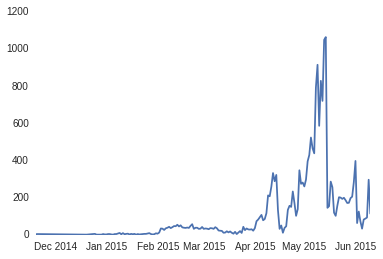

In [61]:
def get_date(timestring):
    mytime = timestring.split('.')[0]
    return datetime.datetime.strptime(mytime, '%Y-%m-%dT%X')
adShows_uniq_only['created_at'].apply(get_date).apply(datetime.datetime.date).value_counts().sort_index().plot()

In [62]:
adShows_uniq_only_small = adShows_uniq_only[['ai','ak','br','co','cr','created_at','cty','dp','dt','ernc','isp','li','lidp','pbep','plfm','rgn','sdpt','ssp','vw_drtn','vw_perc']]

In [63]:
adShows_uniq_only_small

,ai,ak,br,co,cr,created_at,cty,dp,dt,ernc,isp,li,lidp,pbep,plfm,rgn,sdpt,ssp,vw_drtn,vw_perc
0,67,130,Android 0.0,ITA,218,2015-04-29T19:43:15.724Z,NaN,2000,android,1400,H3G Italy,130,0,70,android,NaN,0,zenit_marketplace,0,0
1,52,125,Other 0.0,GBR,61,2015-02-23T02:02:01.345Z,Liverpool,3000,other,2100,Sky Broadband,50,0,70,NaN,NaN,5,NaN,0,0
2,67,130,Android 0.0,ITA,190,2015-04-25T19:25:50.073Z,Milan,2000,android,1400,NGI SpA,119,0,70,android,NaN,0,zenit_marketplace,0,0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [64]:
adShows_uniq_only_small.shape

(19872, 20)

In [65]:
adShows_uniq_only_small_dropna = adShows_uniq_only_small.dropna(axis=0)

In [66]:
adShows_uniq_only_small_dropna.shape

(4142, 20)

In [69]:
adShows_uniq_only_small_dropna

,ai,ak,br,co,cr,created_at,cty,dp,dt,ernc,isp,li,lidp,pbep,plfm,rgn,sdpt,ssp,vw_drtn,vw_perc
4,116,42,iPhone,USA,0,2015-05-11T03:08:28.604Z,Mustang,1000,iphone,700,AT&T U-verse,0,0,70,ios,USA-OK,0,vdopia,0,0
10,116,42,iPhone,USA,0,2015-05-06T03:35:00.051Z,Schertz,1000,iphone,700,Time Warner Cable,0,0,70,ios,USA-TX,0,vdopia,0,0
15,116,42,iPhone,USA,0,2015-05-10T21:26:24.841Z,Marion,1000,iphone,700,Verizon Wireless,0,0,70,ios,USA-NC,0,vdopia,0,0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [71]:
def get_browser(br_vs):
    return br_vs.split()[0]
adShows_uniq_only_small_dropna.loc[:, 'br'] = adShows_uniq_only_small_dropna.loc[:, 'br'].apply(get_browser)

In [72]:
def get_date(timestring):
    mytime = timestring.split('.')[0]
    return datetime.datetime.strptime(mytime, '%Y-%m-%dT%X')
adShows_uniq_only_small_dropna.loc[:, 'created_at'] = adShows_uniq_only_small_dropna.loc[:, 'created_at'].apply(get_date)

In [73]:
def get_time_of_day(datetimeObj):
    hour = datetimeObj.hour
    result = 'Evening'
    if hour < 12:
        result = 'Morning'
    elif hour < 16:
        result = 'Afternoon'
    return result
adShows_uniq_only_small_dropna['time'] = adShows_uniq_only_small_dropna['created_at'].apply(get_time_of_day)

In [74]:
adShows_uniq_only_small_dropna['created_at'].apply(lambda x:x.month).value_counts()

5    3761
6     381
dtype: int64

In [75]:
adShows_uniq_only_small_dropna

,ai,ak,br,co,cr,created_at,cty,dp,dt,ernc,isp,li,lidp,pbep,plfm,rgn,sdpt,ssp,vw_drtn,vw_perc,time
4,116,42,iPhone,USA,0,2015-05-11 03:08:28,Mustang,1000,iphone,700,AT&T U-verse,0,0,70,ios,USA-OK,0,vdopia,0,0,Morning
10,116,42,iPhone,USA,0,2015-05-06 03:35:00,Schertz,1000,iphone,700,Time Warner Cable,0,0,70,ios,USA-TX,0,vdopia,0,0,Morning
15,116,42,iPhone,USA,0,2015-05-10 21:26:24,Marion,1000,iphone,700,Verizon Wireless,0,0,70,ios,USA-NC,0,vdopia,0,0,Evening
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


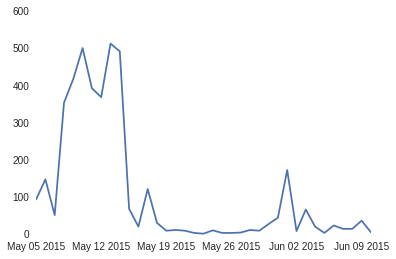

In [76]:
adShows_uniq_only_small_dropna['date'] = adShows_uniq_only_small_dropna['created_at'].apply(datetime.datetime.date)
adShows_uniq_only_small_dropna['date'].value_counts().sort_index().plot()

In [77]:
negative1 = pd.concat([pd.get_dummies(adShows_uniq_only_small_dropna['br'],prefix='br'),pd.get_dummies(adShows_uniq_only_small_dropna['co'],prefix='co'),pd.get_dummies(adShows_uniq_only_small_dropna['cty'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii')),prefix='cty'),pd.get_dummies(adShows_uniq_only_small_dropna['rgn'],prefix='rgn'),pd.get_dummies(adShows_uniq_only_small_dropna['time'],prefix='time'),pd.get_dummies(adShows_uniq_only_small_dropna['dt'],prefix='dt'),pd.get_dummies(adShows_uniq_only_small_dropna['plfm'],prefix='plfm'),pd.get_dummies(adShows_uniq_only_small_dropna['isp'],prefix='isp'),pd.get_dummies(adShows_uniq_only_small_dropna['ssp'],prefix='ssp'),adShows_uniq_only_small_dropna[['dp','ernc','cr','li','lidp','pbep','sdpt','vw_drtn','vw_perc','created_at']]],axis=1)
negative1.shape

(4142, 2039)

There are much more dummy features for negative sets than the positive sets...

What are the different (additional) features?

In [247]:
set(negative1.columns) - set(positive1.columns)

{'isp_Bell Canada',
 'cty_Truro',
 'cty_Camdenton',
 'cty_Canonsburg',
 'rgn_CMR-05',
 'cty_Platte City',
 'isp_Telus Communications',
 'cty_Haslett',
 'isp_Wofford College',
 'cty_Ironwood',
 'cty_Carpentersville',
 'isp_University of Lagos',
 'cty_Providence',
 'cty_Sault Sainte Marie',
 'cty_Homer Glen',
 'cty_Pompano Beach',
 'cty_Bremerton',
 'cty_Prattville',
 'cty_Enid',
 'cty_Bronx',
 'cty_Powder Springs',
 'co_ZWE',
 'cty_Brownstown',
 'cty_Chester',
 'cty_Flint',
 'cty_Brunswick',
 'cty_Platteville',
 'cty_Reno',
 'cty_Hartford',
 'cty_Marshall',
 'cty_Grapevine',
 'cty_New Paltz',
 'cty_Pataskala',
 'cty_Croydon',
 'cty_Vinton',
 'ssp_vdopia',
 'cty_White Lake',
 'cty_Altamonte Springs',
 'cty_Ferrara',
 'cty_Crawley',
 'rgn_MEX-02',
 'cty_Fair Haven',
 'cty_Seri Kembangan',
 'cty_Sea Isle City',
 'rgn_USA-WV',
 'rgn_USA-WY',
 'cty_Dubuque',
 'cty_Syracuse',
 'cty_Sidney',
 'cty_Folsom',
 'cty_San Gregorio Di Catania',
 'cty_Sammamish',
 'cty_Annandale',
 'cty_Marietta',
 'c

In [248]:
set(positive1.columns) - set(negative1.columns)

{'co_ALB',
 'co_AUT',
 'co_BGD',
 'co_CRI',
 'co_KEN',
 'co_NOR',
 'co_TWN',
 'co_TZA',
 'co_UGA',
 'cty_Acerra',
 'cty_Adelfia',
 'cty_Albenga',
 'cty_Alghero',
 'cty_Almenno San Salvatore',
 'cty_Altamura',
 'cty_Amsterdam',
 'cty_Antwerpen',
 'cty_Apo',
 'cty_Arzignano',
 'cty_Asti',
 'cty_Aversa',
 'cty_Azuqueca De Henares',
 'cty_Barolo',
 'cty_Bastiglia',
 'cty_Beckenham',
 'cty_Binago',
 'cty_Bitonto',
 'cty_Bnin',
 'cty_Bologna',
 'cty_Bolton',
 'cty_Borgia',
 'cty_Borgo San Lorenzo',
 'cty_Brindisi',
 'cty_Brugherio',
 'cty_Budrio',
 'cty_Campogalliano',
 'cty_Cape Town',
 'cty_Caravonica',
 'cty_Cardito',
 'cty_Castelfidardo',
 'cty_Castenedolo',
 'cty_Catanzaro',
 'cty_Cavriana',
 'cty_Cittadella',
 'cty_Civitanova Marche',
 'cty_Clifton',
 'cty_Crescentino',
 'cty_Cusano Mutri',
 'cty_Dar Es Salaam',
 'cty_Deerfield Beach',
 'cty_Des Plaines',
 'cty_Dhaka',
 'cty_Dnepropetrovsk',
 'cty_Dunstable',
 'cty_Edgware',
 'cty_Eisenstadt',
 'cty_Foggia',
 'cty_Forl',
 'cty_Giavera 

In [268]:
len(set(positive1.columns) - set(negative1.columns))

235

In [269]:
len(set(negative1.columns) - set(positive1.columns))

1721

It seems that the major differences are in country (co), city, regrion, and isp

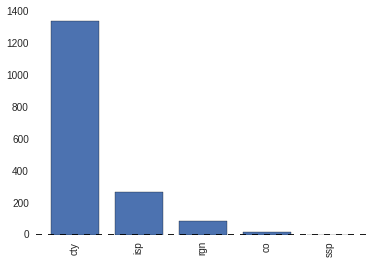

In [264]:
positive1_ids = pd.Series(positive1.columns)
negative1_ids = pd.Series(negative1.columns)
negative1_ids[negative1_ids.apply(lambda x: x in (set(negative1_ids) - set(positive1_ids)))].apply(lambda x: x.split('_')[0]).value_counts().plot(kind='bar')

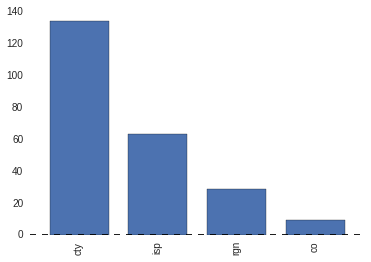

In [263]:
positive1_ids[positive1_ids.apply(lambda x: x in (set(positive1_ids) - set(negative1_ids)))].apply(lambda x: x.split('_')[0]).value_counts().plot(kind='bar')

In [78]:
positive1['click'] = 1
negative1['click'] = 0

Positive1: 1082 x 554

Negative1: 4142 x 2040

shared features: 319

unique features: Positive1 - 235; Negative1 - 1721

If doing outer join, I should get a new dataframe with size 5224 x 2275

In [79]:
data1 = pd.concat([positive1,negative1], axis=0, join='outer')

In [80]:
data1.shape

(5224, 2275)

Filling the missing values here with 0s - boolean false

In [81]:
data1 = data1.fillna(0)

#Final prepare for training set

Data1: 5/5/15 - 6/9/15

Split the data:
Training: 5/5 - 5/25
Validation: 5/26 - 6/1
Test: 6/2 - 6/9

In [82]:
train1 = data1.loc[data1['created_at'].apply(lambda x: x.month == 5 and x.day < 26), :]
train1.shape

(4420, 2275)

In [83]:
validate1 = data1.loc[data1['created_at'].apply(lambda x: ((x.month == 5 and x.day > 25) or (x.month == 6 and x.day < 2))), :]
validate1.shape

(408, 2275)

In [84]:
test1 = data1.loc[data1['created_at'].apply(lambda x: x.month == 6 and x.day > 1), :]
test1.shape

(396, 2275)

In [282]:
train1['click'].value_counts()

0    3651
1     769
dtype: int64

In [283]:
validate1['click'].value_counts()

0    284
1    124
dtype: int64

In [284]:
test1['click'].value_counts()

0    207
1    189
dtype: int64

The click-through-rate seems to be increasing over time...

In [288]:
train1.dtypes

br_Android                                                       float64
br_Chrome                                                        float64
br_iPad                                                          float64
br_iPhone                                                        float64
click                                                              int64
co_AGO                                                           float64
co_ALB                                                           float64
co_ARE                                                           float64
co_AUS                                                           float64
co_AUT                                                           float64
co_BEL                                                           float64
co_BEN                                                           float64
co_BGD                                                           float64
co_BWA                                             

In [289]:
train1.dtypes[train1.dtypes.map(lambda x: x=='object')]

Series([], dtype: object)

In [85]:
click = train1['click'].values

In [86]:
train1 = train1.drop(['created_at','click'], axis=1) 

In [87]:
train1_data = train1.values

In [88]:
forest = RandomForestClassifier(n_estimators = 100)

In [89]:
forest = forest.fit(train1_data,click)

In [90]:
click_validate = validate1['click'].values

In [91]:
validate1_data = validate1.drop(['created_at','click'], axis=1).values

In [92]:
predict1 = forest.predict(validate1_data)

In [93]:
click_validate

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

In [94]:
predict1

array([1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

In [95]:
len(validate1)

408

Accuracy on validation set:

In [318]:
float(np.sum(click_validate == predict1))/len(validate1)

0.8651960784313726

Baseline:

In [319]:
float(np.sum(click_validate == 0))/len(validate1)

0.696078431372549

Precision "P" (TP / TP + FP):

In [323]:
float(np.sum((click_validate == 1)*(click_validate == predict1)))/np.sum(predict1 == 1)

0.9859154929577465

Recall "R" (TP / TP + FN):

In [324]:
float(np.sum((click_validate == 1)*(click_validate == predict1)))/np.sum(click_validate == 1)

0.5645161290322581

F_1 score (2PR/P+R):

In [325]:
2*0.5645161290322581*0.9859154929577465/(0.9859154929577465 + 0.5645161290322581)

0.7179487179487181

In [96]:
def error_analysis(predict, reality):
    precision = float(np.sum((reality == 1)*(reality == predict)))/np.sum(predict == 1)
    recall = float(np.sum((reality == 1)*(reality == predict)))/np.sum(reality == 1)
    f1score = 2*precision*recall/(precision + recall)
    return [precision, recall, f1score]
error_analysis(predict1, click_validate)

[0.9324324324324325, 0.5564516129032258, 0.6969696969696969]

Training error:

In [97]:
predict_train1 = forest.predict(train1_data)

In [98]:
error_analysis(predict_train1, click)

[0.9987012987012988, 1.0, 0.9993502274204028]

Training accuracy is amazing - sign of overfitting (high variace)?

# Feature importances (default: gini)

In [99]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

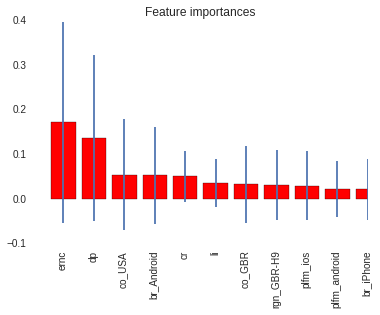

In [139]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(importances)), train1.columns[indices], rotation='vertical')
plt.xlim([-1, 10])
plt.show()

Top 15 features:

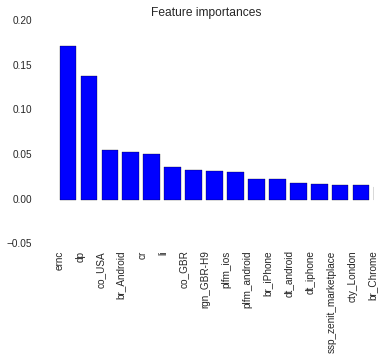

In [140]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices],color="b")
plt.xticks(range(len(importances)), train1.columns[indices], rotation='vertical')
plt.xlim([-1, 15])
plt.savefig("../fig/20150610_RF_feature_top_15.png",format='png')

Combine the importance of features from the same category

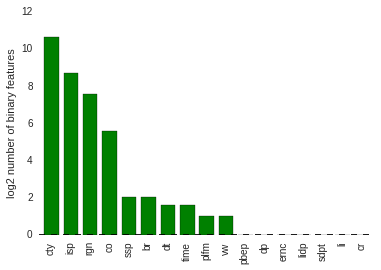

In [114]:
p = pd.value_counts(pd.Series([x.split('_')[0] for x in train1.columns.values])).apply(np.log2).plot(kind='bar',color='g')
p.set_ylabel('log2 number of binary features')
fig = p.get_figure()
fig.savefig('../fig/20150610_RF_feature_count.png',format='png')

Explore time dependence

In [118]:
pd.value_counts(pd.Series([x.split('_')[0] for x in train1.columns.values]))

cty     1598
isp      412
rgn      190
co        48
ssp        4
br         4
dt         3
time       3
plfm       2
vw         2
pbep       1
dp         1
ernc       1
lidp       1
sdpt       1
li         1
...
cty     1598
isp      412
rgn      190
co        48
ssp        4
br         4
dt         3
time       3
plfm       2
vw         2
pbep       1
dp         1
ernc       1
lidp       1
sdpt       1
li         1
cr         1
Length: 17, dtype: int64

In [129]:
features = pd.DataFrame({'feature': train1.columns.values, 'importance': importances, 'type': [x.split('_')[0] for x in train1.columns.values]}, index = range(len(importances)))

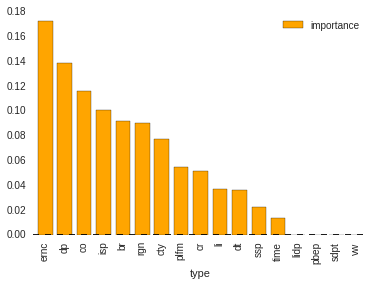

In [143]:
p = features[['type','importance']].groupby('type').sum().sort('importance', ascending = 0).plot(kind='bar',color='orange')
fig = p.get_figure()
fig.savefig('../fig/20150610_RF_feature_sum.png',format='png')

#Time dependence

Per week: 5/5-11, 12-18, 19-25, 5/26-6/1, 2-8

In [151]:
click_cnt = pd.DataFrame({'5/05-5/11': data1.loc[data1['created_at'].apply(lambda x: x.month == 5 and x.day < 12), :]['click'].value_counts(),'5/12-5/18': data1.loc[data1['created_at'].apply(lambda x: x.month == 5 and x.day > 11 and x.day < 19), :]['click'].value_counts(),'5/19-5/25': data1.loc[data1['created_at'].apply(lambda x: x.month == 5 and x.day > 18 and x.day < 26), :]['click'].value_counts(),'5/26-6/1': data1.loc[data1['created_at'].apply(lambda x: ((x.month == 5 and x.day > 25) or (x.month == 6 and x.day < 2))), :]['click'].value_counts(),'6/2-6/8': data1.loc[data1['created_at'].apply(lambda x: x.month == 6 and x.day > 1 and x.day < 9), :]['click'].value_counts()})

In [160]:
click_cnt = click_cnt.transpose()

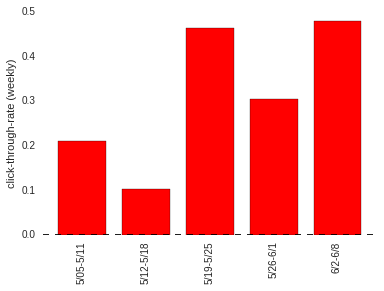

In [169]:
p = (click_cnt[1]/(click_cnt[1] + click_cnt[0])).plot(kind='bar',color='r')
p.set_ylabel('click-through-rate (weekly)')
fig = p.get_figure()
fig.savefig('../fig/20150610_CTR_by_week.png',format='png')

#Explore the idea of user-based model